In [1]:
#type this into the commandline (make sure you're in the right directory)
#mongoexport --db venmo --collection venmo --type=csv --out notes.csv --fields note
import numpy as np
import pandas as pd
import gensim 
import string
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS
from gensim.models import Word2Vec
from collections import Counter
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv("notes.csv")

In [3]:
df = df.dropna()

In [4]:
#break the df into chunks
n = 250000  #chunk row size
df_list = [df[i:i+n] for i in range(0,df.shape[0],n)]
df_list[0] #currently I'm going to work on one chunk only

,note
0,fuk ya
1,🚗
2,:venmo_dollar:
3,Gatorade
4,🎉
...,...
250000,Letting me try on 7 pairs 😎
250001,Fight night 🥊
250002,Big nonsense
250003,Food


In [5]:
corpus = []
for index, row in df_list[0].iterrows():
    note = [word.lower() for word in row["note"].split()]
    corpus.append(note)

In [6]:
model = Word2Vec(corpus, size=100, window=5, min_count=1, workers=4)

In [7]:
#extract feature vector from notes
feature_list = []
for index, row in df_list[0].iterrows():
    note = [word.lower() for word in row["note"].split()]
    for word in note:
        feature = []
        feature.append(model.wv[word])
    feature_list.append(np.average(feature,axis=0))

In [8]:
#split the notes into clusters (still not sure of optimal cluster count)
kmeans = KMeans(n_clusters=13)
kmeans.fit(feature_list)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [9]:
Counter(kmeans.labels_)

Counter({11: 2560,
         2: 16465,
         9: 35373,
         0: 119377,
         5: 41672,
         10: 7661,
         6: 17375,
         4: 3752,
         7: 1053,
         3: 888,
         1: 1740,
         12: 977,
         8: 1107})

In [10]:
pd.options.mode.chained_assignment = None
df_list[0]["label"] = kmeans.labels_

In [11]:
df_list[0]

,note,label
0,fuk ya,11
1,🚗,2
2,:venmo_dollar:,9
3,Gatorade,0
4,🎉,2
...,...,...
250000,Letting me try on 7 pairs 😎,9
250001,Fight night 🥊,0
250002,Big nonsense,0
250003,Food,6


In [12]:
#this function generates a list of common words based on the cluster number you give it (0,1,2,etc.)
def common_words(cluster_num):
    cluster = []
    stop_words = set(stopwords.words('english'))
    for index, row in df_list[0].iterrows():
        if row["label"] == cluster_num:
            note = [word.lower() for word in row["note"].split()]
            for word in note:
                if word not in stop_words:
                    cluster.append(word)
    print("Cluster " + str(cluster_num) + ":")
    print(Counter(cluster).most_common(10))

In [13]:
for i in range(13):
    common_words(i)

Cluster 0:
[('thanks', 650), ('thank', 615), ('+', 572), ('&', 548), ('rent', 439), ('-', 422), ('love', 392), ('get', 374), ('uber', 372), ('last', 369)]
Cluster 1:
[('good', 336), ('night', 312), ('fun', 287), ('time', 279), ('day', 207), ('best', 137), ('last', 118), ('one', 113), ('n', 59), ('da', 47)]
Cluster 2:
[('🚗', 1028), ('🍻', 983), ('🏡', 664), ('🎁', 582), ('groceries', 540), ('🎉', 530), ('lyft', 460), ('💕', 433), ('😊', 422), ('🎟', 384)]
Cluster 3:
[('thank', 267), ('love', 246), ('hate', 23), ('miss', 17), ('bc', 17), ('like', 16), ('owe', 15), ('get', 11), ('money', 11), ('cause', 10)]
Cluster 4:
[('rent', 1694), ('august', 739), ('bill', 605), ('july', 462), ('2', 458), ('1', 271), ('payment', 264), ('part', 190), ('gas', 117), ('pt', 107)]
Cluster 5:
[('🌮🌮', 474), ('💇', 474), (':festival_beer:', 391), ('🌯', 389), ('🚘', 361), ('🥂', 341), ('🍗', 306), ('🍾', 295), ('🍟', 290), ('💩', 288)]
Cluster 6:
[('food', 3665), ('uber', 2325), ('stuff', 1247), ('❤️', 1184), ('😘', 890), ('

In [14]:
#this function generates a wordcloud based on the cluster number you give it (0,1,2,etc.)
def create_cluster_cloud(cluster_num):
    # the regex used to detect words is a combination of normal words, ascii art, and emojis
    # 2+ consecutive letters (also include apostrophes), e.x It's
    normal_word = r"(?:\w[\w']+)"
    # 2+ consecutive punctuations, e.x. :)
    ascii_art = r"(?:[{punctuation}][{punctuation}]+)".format(punctuation=string.punctuation)
    # a single character that is not alpha_numeric or other ascii printable
    emoji = r"(?:[^\s])(?<![\w{ascii_printable}])".format(ascii_printable=string.printable)
    regexp = r"{normal_word}|{ascii_art}|{emoji}".format(normal_word=normal_word, ascii_art=ascii_art, emoji=emoji)
    stopwords = set(STOPWORDS)
    cluster = ' '
    for index, row in df_list[0].iterrows():
        if row["label"] == cluster_num:
            note = [word.lower() for word in row["note"].split()]
            for word in note:
                cluster = cluster + word + ' '
    wordcloud = WordCloud(font_path = "Symbola.ttf", width=1000, height=1000, stopwords = stopwords, regexp = regexp).generate(cluster)
    plt.figure(figsize = (10, 10))
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show() 

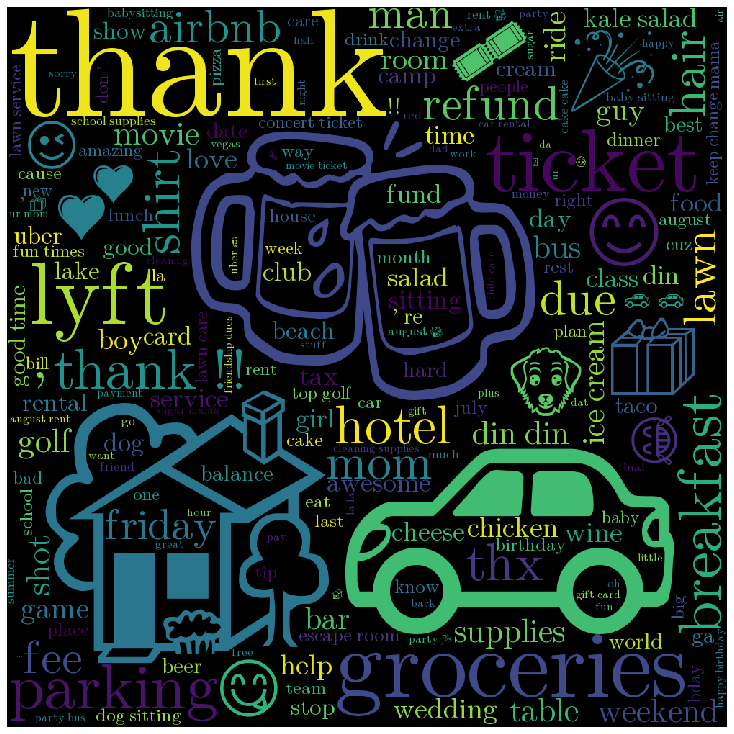

In [15]:
create_cluster_cloud(2)

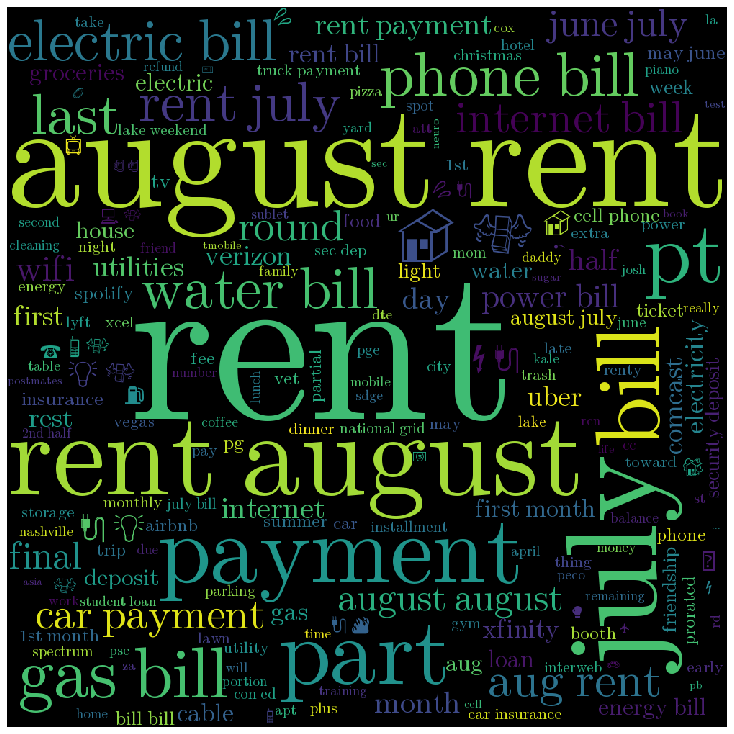

In [16]:
create_cluster_cloud(4)

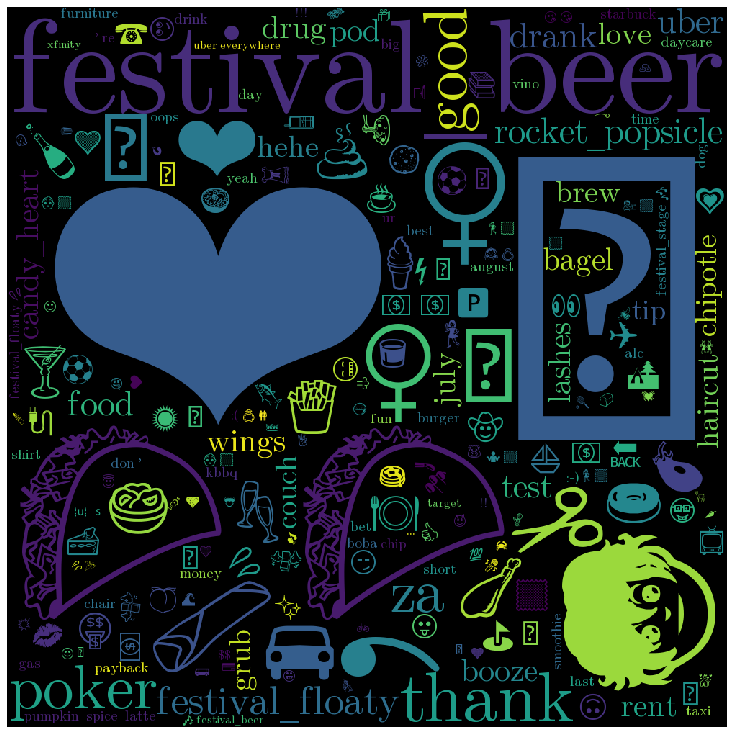

In [17]:
create_cluster_cloud(5)

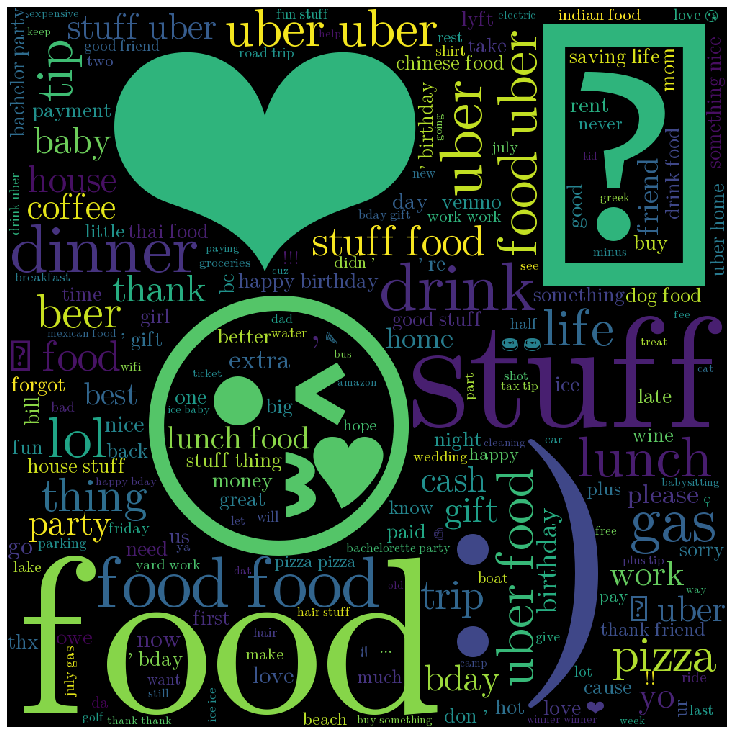

In [18]:
create_cluster_cloud(6)

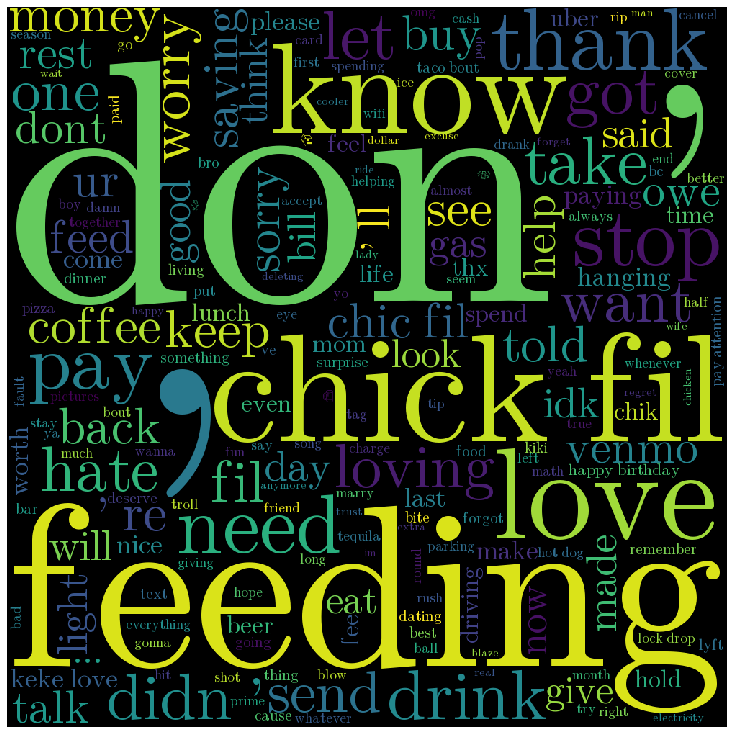

In [19]:
create_cluster_cloud(8)

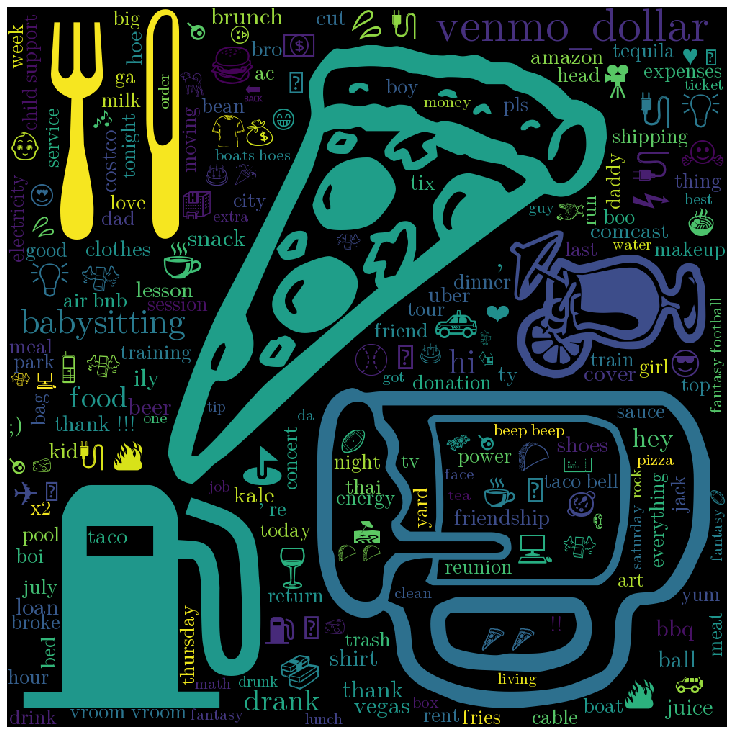

In [20]:
create_cluster_cloud(9)

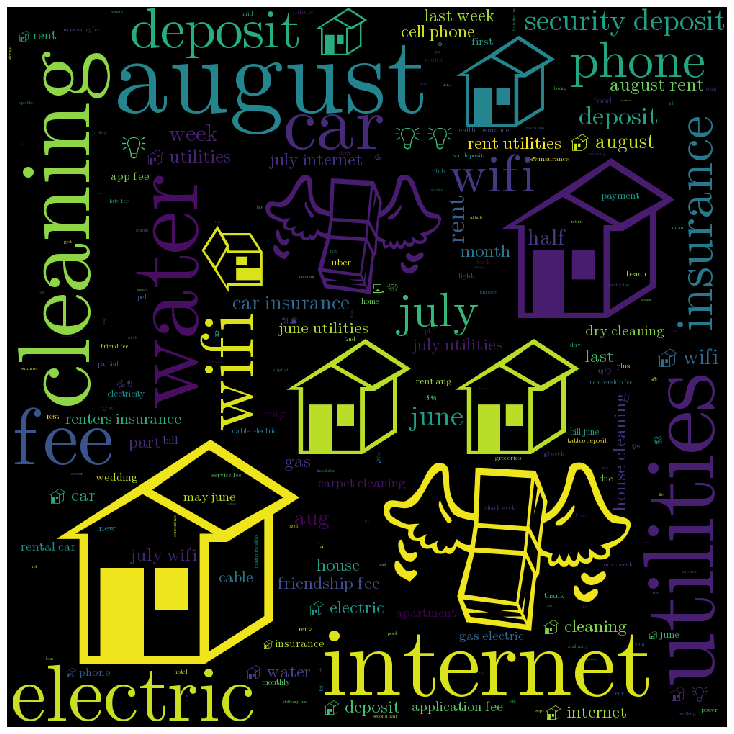

In [21]:
create_cluster_cloud(10)

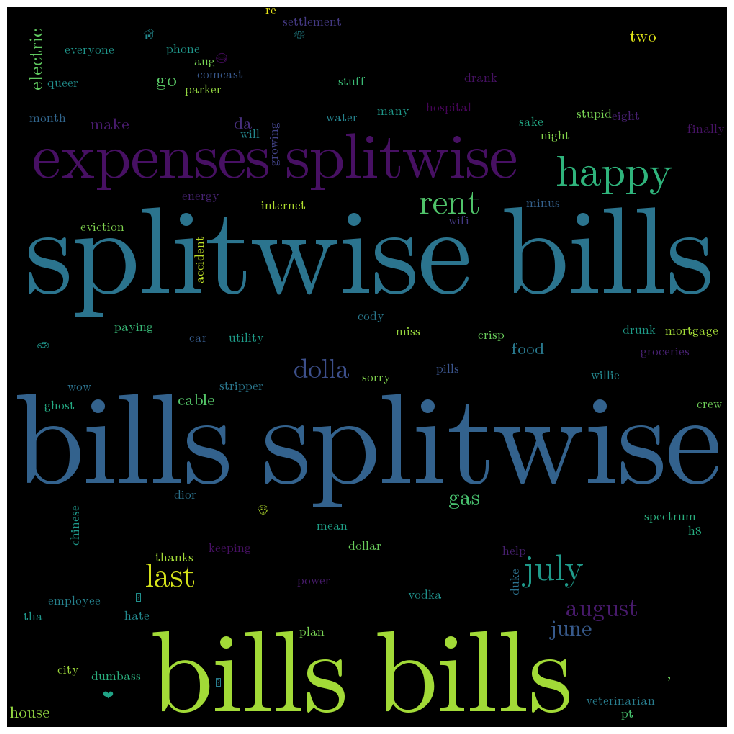

In [22]:
create_cluster_cloud(12)